In [32]:
using LinearAlgebra
using Plots
using ProgressMeter
using Random
using SparseArrays

In [33]:
const L  = 20π       # Domain size
const DT = 0.005     # Time step
const NT = 10000     # Number of time steps
const NG = 320       # Number of grid cells
const N  = NG * 20   # Number of particles
const WP = 1.        # Plasma frequency
const QM = -1.       # Charge/mass ratio
const V0 = 0.9       # Stream velocity
const VT = 0.0000001 # Thermal speed

# perturbation 
const XP1 = 1.0 
const mode = 1

const Q = WP^2 / (QM*N/L)  # rho0*L/N: charge carried by a single particle?
const rho_back = -Q*N/L  # Background charge density?
const dx = L / NG # Grid step

0.19634954084936207

In [45]:
struct Deposition
    g :: Vector{Int}
    f :: Vector{Float64}
    p
    function Deposition(N, NG)
        g = zeros(Int, N)
        f = zeros(Float64, N)
        p = [1:N; 1:N]
        new( g, f, p)
    end
end

function compute_rho!(rho, d, xp)
    # Project particles -> grid
    d.f .= xp ./ dx .- 0.5
    d.g .= floor.(Int, d.f)
    g = vcat(d.g, d.g .+ 1)
    d.f .= 1 .- abs.(d.f .- d.g)
    f = vcat(d.f, 1 .- d.f)
    g .= mod1.(g, NG)
    mat = sparse(d.p, g, f, N, NG)
    dropzeros!(mat)
    rho .= Q / dx * vec(sum(mat,dims=1)) .+ rho_back
    return mat
end

compute_rho! (generic function with 1 method)

In [46]:
function solve!( Eg, rho, Poisson )
    # Compute electric field potential
    rho .*= (-dx^2)
    rho .= Poisson \ rho
    Eg[1:end-1] .= rho[1:end-1]
    Eg[end] = 0.0
    # Electric field on the grid
    Eg .= (circshift(Eg, 1) .- circshift(Eg, -1)) ./ (2dx)
end  

solve! (generic function with 1 method)

In [47]:
function update_position!(xp, vp, DT)
    # update particle position xp
    for i in eachindex(xp)
        xp[i] += vp[i] * DT
        xp[i] = mod( xp[i], L) # Periodic boundary condition 
    end
end

update_position! (generic function with 1 method)

In [48]:
function main()
    
    # Cell center coordinates
    xg = collect(LinRange(0, L, NG+1))[1:end-1] .+ dx/2
    xp = collect(LinRange(0, L, N+1))[1:end-1]  # Particle positions
    
    rng = MersenneTwister(1234)
    
    vp = VT .* (1 .- VT.^2).^(-0.5) .* randn(rng, Float64, N) # Particle momentum, initially Maxwellian
    pm = collect(0:N-1)
    pm = 1 .- 2 * mod.(pm.+1, 2)
    vp .+= pm * (V0 * (1 - V0^2)^(-0.5)) # Momentum + stream velocity
    
    # Add electron perturbation to excite the desired mode
    xp .+= XP1 * (L/N) * sin.(2 * π * xp / L * mode)
    xp[xp .< 0] .+= L #periodic boundary condition
    xp[xp .> L] .-= L
    
    Poisson = spdiagm(-1 => ones(Float64,NG-2),
                      0 => -2*ones(Float64,NG),
                      1 => ones(Float64,NG-2));
    
    b = Progress(NT+1)
    PotE = Float64[]
    Eg = zeros(Float64,NG)
    rho = zeros(Float64,NG)
    d = Deposition( N, NG)
    
    for it in 1:NT+1
        update_position!(xp, vp, DT) 
        mat = compute_rho!(rho, d, xp)
        solve!(Eg, rho, Poisson)
        vp .+= mat * QM * Eg * DT
        push!(PotE, 0.5 * sum(Eg.^2) * dx) 
        #plt = plot()
        #xlims!(0, L)
        #ylims!(-7, 7)
        #scatter!(plt, xp[1:2:end], vp[1:2:end], marker = (:circle, 2, 1., :blue, stroke(1, 0.2, :blue, :dot)))
        #scatter!(plt, xp[2:2:end], vp[2:2:end], marker = (:circle, 2, 1., :red, stroke(1, 0.2, :red, :dot)))
        next!(b)
    end #every 50
    PotE
end

main (generic function with 1 method)

In [49]:
@time results = main();

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


  9.203988 seconds (1.02 M allocations: 11.969 GiB, 13.09% gc time)


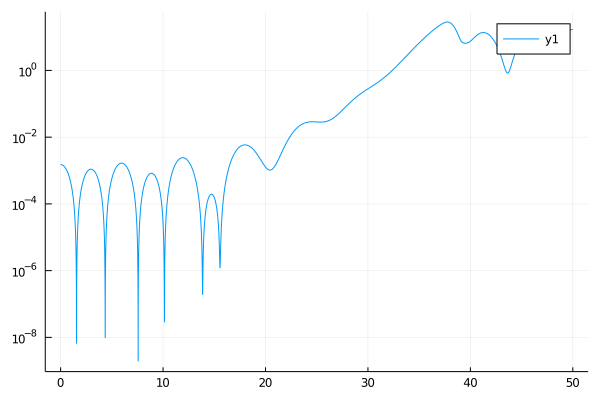

In [50]:
t = (0:NT) .* DT

plot( t, results, yaxis=:log)